[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1AoolDYePUpPkRCKIu0cP9zV7lX5QGD3Z?usp=sharing)

In [1]:
!pip install rudalle==0.0.1rc8 > /dev/null

You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [2]:
ALLOWED_MEMORY = 3.5 # choose your GPU memory in GB  
if ALLOWED_MEMORY < 4.5:
    DALLE_BS = 1
elif ALLOWED_MEMORY < 5.5:
    DALLE_BS = 2
elif ALLOWED_MEMORY < 6.5:
    DALLE_BS = 3
elif ALLOWED_MEMORY < 7.5:
    DALLE_BS = 4
elif ALLOWED_MEMORY < 8.5:
    DALLE_BS = 5
elif ALLOWED_MEMORY < 9.5:
    DALLE_BS = 6
elif ALLOWED_MEMORY < 10.5:
    DALLE_BS = 7
else:
    DALLE_BS = 8
    
print('ruDALL-E batch size:', DALLE_BS)

ruDALL-E batch size: 1


In [3]:
import multiprocessing
import torch
from psutil import virtual_memory

total_memory = torch.cuda.get_device_properties(0).total_memory / 2**30
if total_memory < ALLOWED_MEMORY:
    raise MemoryError
print('Total GPU RAM:', round(total_memory, 2), 'Gb')

ram_gb = round(virtual_memory().total / 1024**3, 1)
print('CPU:', multiprocessing.cpu_count())
print('RAM GB:', ram_gb)
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

if torch.__version__ >= '1.8.0':
    k = ALLOWED_MEMORY/ total_memory
    torch.cuda.set_per_process_memory_fraction(k, 0)
    print('Allowed GPU RAM:', round(ALLOWED_MEMORY, 2), 'Gb')
    print('GPU part', round(k, 4))
!nvidia-smi

Total GPU RAM: 23.69 Gb
CPU: 32
RAM GB: 125.7
PyTorch version: 1.9.0+cu111
CUDA version: 11.1
cuDNN version: 8005
Allowed GPU RAM: 3.5 Gb
GPU part 0.1477
Wed Nov 10 16:50:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:04:00.0 Off |                  N/A |
| 53%   47C    P2   120W / 350W |   1807MiB / 24260MiB |     17%      Default |
|                               |                      |                  N/A |
+-------------

In [4]:
import transformers
import more_itertools
from tqdm.auto import tqdm

from rudalle.pipelines import show, cherry_pick_by_clip
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_ruclip
from rudalle.utils import seed_everything, torch_tensors_to_pil_list

# prepare models:
device = 'cuda'
dalle = get_rudalle_model('Malevich', pretrained=True, fp16=True, device=device)
tokenizer = get_tokenizer()
vae = get_vae(dwt=True)

# prepare utils:
ruclip, ruclip_processor = get_ruclip('ruclip-vit-base-patch32-v5')

◼️ Malevich is 1.3 billion params model from the family GPT3-like, that uses Russian language and text+image multi-modality.
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready
ruclip --> ready


In [5]:
def generate_codebooks(text, tokenizer, dalle, top_k, top_p, images_num, image_prompts=None, temperature=1.0, bs=8,
                    seed=None, use_cache=True):
    vocab_size = dalle.get_param('vocab_size')
    text_seq_length = dalle.get_param('text_seq_length')
    image_seq_length = dalle.get_param('image_seq_length')
    total_seq_length = dalle.get_param('total_seq_length')
    device = dalle.get_param('device')
    text = text.lower().strip()
    input_ids = tokenizer.encode_text(text, text_seq_length=text_seq_length)
    codebooks = []
    for chunk in more_itertools.chunked(range(images_num), bs):
        chunk_bs = len(chunk)
        with torch.no_grad():
            attention_mask = torch.tril(torch.ones((chunk_bs, 1, total_seq_length, total_seq_length), device=device))
            out = input_ids.unsqueeze(0).repeat(chunk_bs, 1).to(device)
            has_cache = False
            if image_prompts is not None:
                prompts_idx, prompts = image_prompts.image_prompts_idx, image_prompts.image_prompts
                prompts = prompts.repeat(chunk_bs, 1)
            for idx in tqdm(range(out.shape[1], total_seq_length)):
                idx -= text_seq_length
                if image_prompts is not None and idx in prompts_idx:
                    out = torch.cat((out, prompts[:, idx].unsqueeze(1)), dim=-1)
                else:
                    logits, has_cache = dalle(out, attention_mask,
                                              has_cache=has_cache, use_cache=use_cache, return_loss=False)
                    logits = logits[:, -1, vocab_size:]
                    logits /= temperature
                    filtered_logits = transformers.top_k_top_p_filtering(logits, top_k=top_k, top_p=top_p)
                    probs = torch.nn.functional.softmax(filtered_logits, dim=-1)
                    sample = torch.multinomial(probs, 1)
                    out = torch.cat((out, sample), dim=-1)
            codebooks.append(out[:, -image_seq_length:].cpu())
    return codebooks

In [6]:
text = 'Пингвины радуются - неизвестная картина Казимира Малевича'

seed_everything(6955)
codebooks = []
for top_k, top_p, images_num in [
    (2048, 0.995, 8),
    (1536, 0.99, 8),
#     (1024, 0.99, 8),
#     (1024, 0.98, 8),
#     (512, 0.97, 8),
#     (384, 0.96, 8),
#     (256, 0.95, 8),
#     (128, 0.95, 8),
]:
    codebooks += generate_codebooks(text, tokenizer, dalle, top_k=top_k, images_num=images_num, top_p=top_p, bs=DALLE_BS)

  0%|          | 0/1024 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

In [7]:
pil_images = []
for _codebooks in tqdm(torch.cat(codebooks).cpu()):
    with torch.no_grad():
        images = vae.decode(_codebooks.unsqueeze(0))
        pil_images += torch_tensors_to_pil_list(images)

  0%|          | 0/16 [00:00<?, ?it/s]

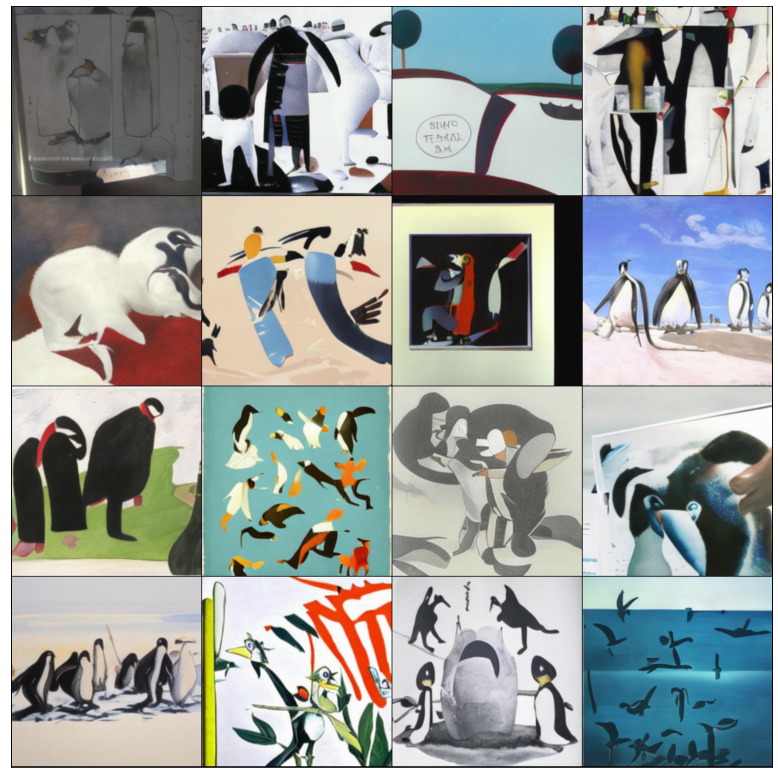

In [8]:
show(pil_images, 4)

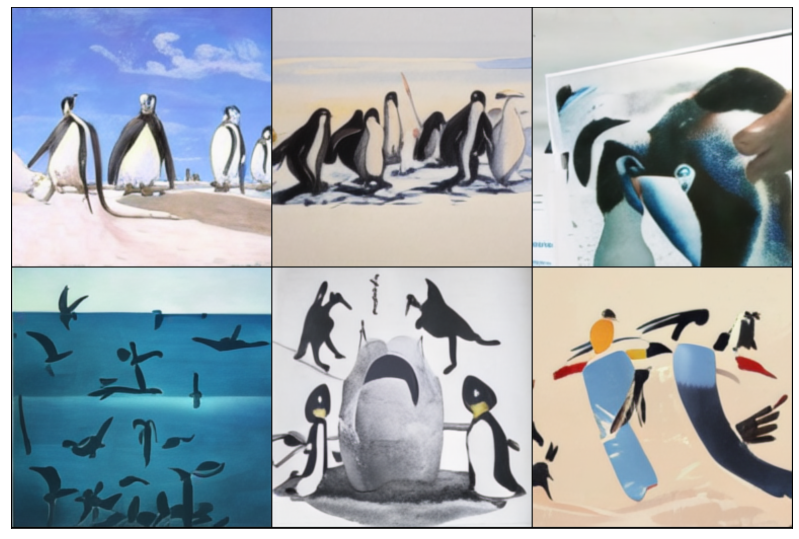

In [9]:
top_images, clip_scores = cherry_pick_by_clip(pil_images, text, ruclip, ruclip_processor, device='cpu', count=6)
show(top_images, 3)